In [531]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split


from datetime import date, timedelta
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
import joblib
from lib.Measures import measureDataframe2
from lib.Utility import exportExcelWithTimeStamp
import plotly.express as px
from plotly import graph_objects as go
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

commissioni = 0.0005
threshold = 0.5
features2 = ['feat_Open-PrevClose']
features = ['feat_vvixPrevClose','feat_vvixOpen']

In [532]:
tomorrow = date.today() - timedelta(50)
start = "1990-09-04"
# tomorrow = "2023-09-04"

data = yf.download (tickers = "^SPX", start = start,
                              end = tomorrow, interval = "1d").reset_index()
vix = yf.download (tickers = "^VIX", start = start,
                              end = tomorrow, interval = "1d").reset_index()
vvix = yf.download (tickers = "^VVIX", start = start,
                              end = tomorrow, interval = "1d").reset_index()
# vixl = yf.download (tickers = "VIXL.L", start = start,
#                               end = tomorrow, interval = "1d").reset_index()
# print(vixl)
scaler = preprocessing.MinMaxScaler()
data['feat_Open'] = scaler.fit_transform(data['Open'].values.reshape(-1, 1))
data['feat_Open-PrevClose'] = np.where(data['Open']-data['Close'].shift(1)>0,1,0)

vix['feat_vixOpen'] = vix['Open']
vix['feat_vixPrevClose'] = vix['Close'].shift(1)
vvix['feat_vvixOpen'] = vvix['Open']
vvix['feat_vvixPrevClose'] = vvix['Close'].shift(1)
vvix['feat_vvixPrevOpen'] = vvix['Open'].shift(1)
vvix['feat_vvixPrevHigh'] = vvix['High'].shift(1)
vvix['feat_vvixPrevHigh-Low'] = vvix['High'].shift(1)-vvix['Low'].shift(1)
vvix['feat_Acc'] = np.where(vvix['Close'].shift(1) > vvix['Close'].shift(2), 1, 0)
vvix['feat_vvixPrevLow'] = vvix['Low'].shift(1)

vix = vix.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)
vvix = vvix.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)

data = data.merge(vix, how='left', on='Date')# VIX
data = data.merge(vvix, how='left', on='Date')# vVIX

data['Cluster'] = np.where(data['Close'] > data['Open'], 1, -1)
# data['Cluster'] = np.where(data['Close'] > data['Open']+data['Open']*0.001, 1, np.where(data['Close'] < data['Open']-data['Open']*0.001, -1,0))
data['feat_PrevCluster'] = data['Cluster'].astype('Int64').shift(1)
data['feat_bigBodyRange'] = np.where(abs(data['Close'] - data['Open'])/data['Open'] > 0.01, 1, 0)

data =data.dropna()
# data.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [533]:
# features = [col for col in data.columns if 'feat' in col]

print(features)

x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 1,shuffle=True)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()


x_train2, x_test2, y_train2, y_test2 = train_test_split(data[features2], data['Cluster'], test_size= 0.3, random_state= 1,shuffle=True)

x_train2 = x_train2.sort_index()
x_test2 = x_test2.sort_index()
y_train2= y_train2.sort_index()
y_test2 = y_test2.sort_index()


print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')

['feat_vvixPrevClose', 'feat_vvixOpen']
X_train: (3064, 2) 
X_test: (1314, 2) 
y_train: (3064,) 
y_test: (1314,)


In [534]:
# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear", random_state=42).fit(x_train, y_train)
model2 = LogisticRegression(C=1/reg, solver="liblinear", random_state=42).fit(x_train2, y_train2)

joblib.dump(model, "./LogRegB-Class2.joblib")
joblib.dump(model2, "./LogRegB-Class22.joblib")

print (model)

LogisticRegression(C=100.0, random_state=42, solver='liblinear')


In [535]:
df = x_test.copy()

df['predictions'] = model.predict(x_test)
df['y_test'] = y_test

df2 = x_test2.copy()

df2['predictions'] = model2.predict(x_test2)
df2['y_test'] = y_test2

print(f"Accuracy score: {accuracy_score(df['y_test'], df['predictions'])}")
print(f"Accuracy score: {accuracy_score(df2['y_test'], df2['predictions'])}")

df3 = pd.DataFrame(model.predict_proba(x_test))
df5 = pd.DataFrame(model2.predict_proba(x_test2))
df = pd.concat([df, df3])
df2 = pd.concat([df, df5])
# print(df)
# df.to_excel('pippo.xlsx')


Accuracy score: 0.6537290715372908
Accuracy score: 0.5821917808219178


In [536]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve

clf = [
    LogisticRegression(solver='newton-cg',penalty=None,max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty=None,max_iter=1000),
    LogisticRegression(solver='sag',penalty=None,max_iter=1000),
    LogisticRegression(solver='saga',penalty=None,max_iter=1000)
    ]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:
        
    predicted = alg.fit(x_train, y_train).predict(x_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(x_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(x_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)

    row_index+=1
    
clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.63349,0.65373,0.63904,0.82535,0.63867
1,0.63349,0.65373,0.63904,0.82535,0.63867
3,0.63381,0.64764,0.63799,0.80423,0.63390
2,0.63381,0.64688,0.63758,0.80282,0.63320


In [537]:
clf = [
    LogisticRegression(solver='newton-cg',penalty='l2',max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',max_iter=1000),
    LogisticRegression(solver='sag',penalty='l2',max_iter=1000),
    LogisticRegression(solver='saga',penalty='l2',max_iter=1000)
    ]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:
        
    predicted = alg.fit(x_train, y_train).predict(x_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(x_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(x_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)

    row_index+=1
    
clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.63349,0.65373,0.63904,0.82535,0.63867
1,0.63349,0.65373,0.63904,0.82535,0.63867
2,0.63381,0.64764,0.63799,0.80423,0.63390
3,0.63381,0.64764,0.63799,0.80423,0.63390


In [538]:
clf = [
    LogisticRegression(solver='newton-cg',penalty='l2', C=0.001, max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',C=0.001, max_iter=1000),
    LogisticRegression(solver='sag',penalty='l2',C=0.001, max_iter=1000),
    LogisticRegression(solver='saga',penalty='l2',C=0.001, max_iter=1000)
    ]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:
        
    predicted = alg.fit(x_train, y_train).predict(x_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(x_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(x_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)

    row_index+=1
    
clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.63218,0.64840,0.62998,0.84648,0.63102
1,0.63218,0.64840,0.62998,0.84648,0.63102
2,0.63381,0.64764,0.63209,0.83239,0.63143
3,0.63316,0.64764,0.63209,0.83239,0.63143


C:\Users\vitto\AppData\Local\Temp\ipykernel_29736\2790953113.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitto\AppData\Local\Temp\ipykernel_29736\2790953113.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Misure per 5.475 anni
Benchmark Equity: 970.3410034179688
Equity 6144.895235992428
Maximum number of loss operation: 8
Maximum DrawDown: -183.4757396240202
SGR: 1122.3552942451925 vs Benchmark: 177.23123350099888
Win Rate: 63.55140186915888
Long Equity 4564.432678222656
Short Equity 3594.0916748046875


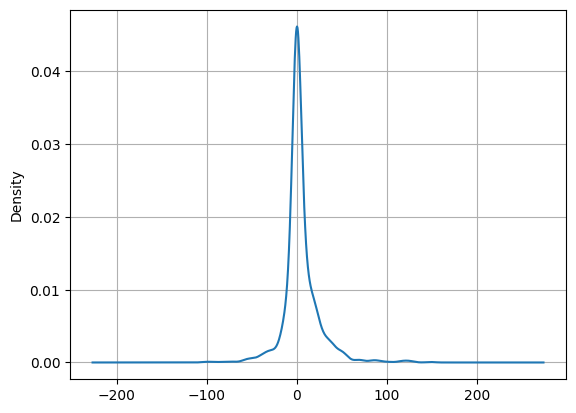

In [539]:

# Seleziona le colonne con il prefisso "feat"
feat_cols = [col for col in data.columns if 'feat' in col]

test_data = data[data.index.isin(x_test.index)]
test_data['cluster'] = model.predict(x_test)
test_data['cluster2'] = model2.predict(x_test2)

df3 = pd.DataFrame(model.predict_proba(x_test))
df3.index = test_data.index
test_data = test_data.merge(df3, left_index=True, right_index=True)

df_test = pd.DataFrame(test_data)
df_test['color'] = np.where(test_data['cluster']==1,'green','red')

# Calcoliamo la variazione percentuale dei prezzi di chiusura
#df_live['pct_change'] = df_live['Close'].pct_change()
df_test['pct_change'] = (df_test['Close']-df_test['Open'])#/df_live['Open']

df_test['commissione'] = commissioni*df_test['Open']

# df_live['gainVolFilter'] = np.where(df_live['bigBodyRangePred'] == 1, (df_live['signal']*df_live['pct_change'])-commissioni, 0)
df_test['longGain'] = np.where(df_test['cluster'] == 1,df_test['cluster']*df_test['pct_change'], 0)
df_test['shortGain'] = np.where(df_test['cluster'] == -1, df_test['cluster']*df_test['pct_change'], 0) 

df_test['signal'] = np.where((df_test[0] >= threshold) & (df_test['cluster2'] == -1), -1, np.where((df_test[1] >= threshold) & (df_test['cluster2'] == 1), 1, 0))
# df_test['signal'] = np.where((df_test[0] >= threshold) , -1, np.where((df_test[1] >= threshold), 1, 0))

df_test['gain'] = (df_test['signal']*df_test['pct_change'])-df_test['commissione']*abs(df_test['signal'])
df_test['equity'] = np.cumsum(df_test['gain'])
# df_test['signal'] = np.where(df_test['cluster'] == 1, 1, np.where(df_test['cluster'] == -1, -1, 0))
# df_test['gain'] = (df_test['cluster']*df_test['pct_change'])-df_test['commissione']
# df_test['equity'] = np.cumsum(df_test['gain'])
# df_live['equityVolatilityFilter'] = np.cumsum(df_live['gainVolFilter'])

measureDataframe2(df_test)
exportExcelWithTimeStamp(df_test, "Equity/", "TestEquity.xlsx")

fig = go.Figure(data=[go.Candlestick(x=test_data['Date'],
                open=test_data['Open'],
                close=test_data['Close'], high=test_data['High'], low=test_data['Low'], opacity=0.5)])
sec_y = go.layout.YAxis(title='Equity')#, offset=dict(type="absolute", value=0.25))
fig.add_trace(go.Scatter(x=df_test['Date'], y=df_test['equity'], name='Equity', line=dict(color='blue')) )
fig.add_scatter(x=test_data['Date'], y=test_data['Open'], mode='markers',marker=dict(color=df_test['color']))
# fig.add_trace(go.Line(x=df['Date'], y=df['equity'], name='Equity'))
# fig.add_trace(go.Scatter(x=df_live['Date'], y=df_live['equityVolatilityFilter'], name='Equity Volatility Filter'))




fig.update_layout(
    xaxis_rangeslider_visible=False,
                  yaxis2=dict(
        title='Equity',
        overlaying='y',  # Sovrappone il secondo asse y al primo
        side='right',  # Posiziona il secondo asse y a destra
        showgrid=False  # Nasconde la griglia per il secondo asse y se necessario
    ))
# Associa la serie Equity al secondo asse y
fig.data[1].update(yaxis='y2')
fig.show()

# Plot distribution of values in Marks column
df_test['gain'].plot(kind='kde')
plt.grid()

## LIVE

In [540]:
before = date.today() - timedelta(400)
tomorrow = date.today() + timedelta(1)

dataLive = yf.download (tickers = "^SPX", start = before,
                              end = tomorrow, interval = "1d").reset_index()
vixLive = yf.download (tickers = "^VIX", start = before,
                              end = tomorrow, interval = "1d").reset_index()
vvixLive = yf.download (tickers = "^VVIX", start = before,
                              end = tomorrow, interval = "1d").reset_index()

scaler = preprocessing.MinMaxScaler()
dataLive['feat_Open'] = scaler.fit_transform(dataLive['Open'].values.reshape(-1, 1))
dataLive['feat_Open-PrevClose'] = np.where(dataLive['Open']-dataLive['Close'].shift(1)>0,1,0)
vixLive['feat_vixOpen'] = vixLive['Open']
vixLive['feat_vixPrevClose'] = vixLive['Close'].shift(1)
vvixLive['feat_vvixOpen'] = vvixLive['Open']
vvixLive['feat_vvixPrevClose'] = vvixLive['Close'].shift(1)
vvixLive['feat_vvixPrevLow'] = vvixLive['Low'].shift(1)
#data['feat_VolChange'] = (data['Volume'].shift(1) - data['Volume'].shift(2)) / data['Volume'].shift(2)
# data['feat_prevClose'] = data['Close'].shift(1)
# data['bigBodyRange'] = np.where(abs(data['Close'] - data['Open'])/data['Open'] > 0.004, 1, 0)
vvixLive['feat_vvixPrevOpen'] = vvixLive['Open'].shift(1)
vvixLive['feat_vvixPrevHigh'] = vvixLive['High'].shift(1)
vvixLive['feat_vvixPrevHigh-Low'] = vvixLive['High'].shift(1)-vvixLive['Low'].shift(1)
vvixLive['feat_Acc'] = np.where(vvixLive['Close'].shift(1) > vvixLive['Close'].shift(2), 1, 0)
vixLive = vixLive.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)
vvixLive = vvixLive.drop(['Open','Close', 'High','Low', 'Adj Close', 'Volume'], axis=1)

dataLive['feat_Open'] = dataLive['Open']
dataLive = dataLive.merge(vixLive, how='left', on='Date')# VIX
dataLive = dataLive.merge(vvixLive, how='left', on='Date')# vVIX

dataLive['Cluster'] = np.where(dataLive['Close'] > dataLive['Open'], 1, -1)
# dataLive['Cluster'] = np.where(dataLive['Close'] > dataLive['Open']+dataLive['Open']*0.001, 1, np.where(dataLive['Close'] < dataLive['Open']-dataLive['Open']*0.001, -1,0))
dataLive['feat_PrevCluster'] = dataLive['Cluster'].astype('Int64').shift(1)
dataLive['feat_bigBodyRange'] = np.where(abs(dataLive['Close'] - dataLive['Open'])/dataLive['Open'] > 0.01, 1, 0)



dataLive =dataLive.dropna()
# dataLive.head(15)
vvixLive.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,feat_vvixOpen,feat_vvixPrevClose,feat_vvixPrevLow,feat_vvixPrevOpen,feat_vvixPrevHigh,feat_vvixPrevHigh-Low,feat_Acc
270,2024-07-23,93.540001,93.660004,90.599998,97.519997,97.519997,6.919998,0
271,2024-07-24,93.059998,88.510002,87.940002,93.540001,94.250000,6.309998,0
272,2024-07-25,104.220001,106.120003,89.720001,93.059998,106.970001,17.250000,1
273,2024-07-26,101.099998,104.379997,95.540001,104.220001,109.660004,14.120003,0
274,2024-07-29,96.349998,94.610001,93.870003,101.099998,101.529999,7.659996,0


In [541]:
# CLASSIFICATION
clf = loaded_rf = joblib.load("./LogRegB-Class2.joblib")

# Seleziona le colonne con il prefisso "feat"
# features = [col for col in data.columns if 'feat' in col]
# features = ['feat_Open', 'feat_vixOpen', 'feat_vixPrevClose', 'feat_vvixOpen', 'feat_Acc', 'feat_bigBodyRange']
print(features)

x_live = dataLive[features]

y_live_pred = clf.predict(x_live)
dataLive['cluster'] = y_live_pred

print(f"Accuracy score: {accuracy_score(dataLive['Cluster'], dataLive['cluster'])}")

df4 = pd.DataFrame(model.predict_proba(x_live))
df4.index = dataLive.index
dataLive = dataLive.merge(df4, left_index=True, right_index=True)

df_live = pd.DataFrame(dataLive)
# dataLive['signal'] = np.where(dataLive['cluster'] == 1, 1, np.where(dataLive['cluster'] == 0, -1, 0)) 
dataLive['color'] = np.where(dataLive['cluster']==1,'green','red')


# Calcoliamo la variazione percentuale dei prezzi di chiusura
#df_live['pct_change'] = df_live['Close'].pct_change()
df_live['pct_change'] = (df_live['Close']-df_live['Open'])#/df_live['Open']
# df_live['signal'] = np.where(df_live['cluster'] == 1, 1, np.where(df_live['cluster'] == -1, -1, 0)) 
df_live['commissione'] = abs(df_live['cluster'])*commissioni*df_live['Open']

# df_live['gainVolFilter'] = np.where(df_live['bigBodyRangePred'] == 1, (df_live['signal']*df_live['pct_change'])-commissioni, 0)
df_live['longGain'] = np.where(df_live['cluster'] == 1, (df_live['cluster']*df_live['pct_change']), 0)
df_live['shortGain'] = np.where(df_live['cluster'] == -1, (df_live['cluster']*df_live['pct_change']), 0)  

# df_live['gain'] = (df_live['cluster']*df_live['pct_change'])-df_live['commissione']
# df_live['equity'] = np.cumsum(df_live['gain'])
# df_live['equityVolatilityFilter'] = np.cumsum(df_live['gainVolFilter'])
df_live['signal'] = np.where(df_live[0] >= threshold, -1, np.where(df_live[1] >= threshold, 1, 0))
df_live['gain'] = (df_live['signal']*df_live['pct_change'])-df_live['commissione']*abs(df_live['signal'])
df_live['equity'] = np.cumsum(df_live['gain'])

measureDataframe2(df_live)

exportExcelWithTimeStamp(df_live, "Equity/", "LiveEquity.xlsx")

# LIVE

fig = go.Figure(data=[go.Candlestick(x=df_live['Date'],
                open=df_live['Open'],
                close=df_live['Close'], high=df_live['High'], low=df_live['Low'], opacity=0.5)])
# sec_y = go.layout.YAxis(title='Equity')#, offset=dict(type="absolute", value=0.25))

# fig.add_trace(go.Line(x=df_live['Date'], y=df_live['equity'], name='Equity'))
fig.add_trace(go.Scatter(x=df_live['Date'], y=df_live['equity'], name='Equity', line=dict(color='blue')) )
fig.add_scatter(x=df_live['Date'], y=df_live['Open'], mode='markers',marker=dict(color=dataLive['color']))

fig.update_layout(
    xaxis_rangeslider_visible=False,
                  yaxis2=dict(
        title='Equity',
        overlaying='y',  # Sovrappone il secondo asse y al primo
        side='right',  # Posiziona il secondo asse y a destra
        showgrid=False  # Nasconde la griglia per il secondo asse y se necessario
    ))
# Associa la serie Equity al secondo asse y
fig.data[1].update(yaxis='y2')
fig.show()

['feat_vvixPrevClose', 'feat_vvixOpen']
Accuracy score: 0.5437956204379562
Misure per 1.1416666666666666 anni
Benchmark Equity: 380.833984375
Equity -524.0970712890623
Maximum number of loss operation: 5
Maximum DrawDown: -712.7330595703123
SGR: -459.063128136405 vs Benchmark: 333.5772125912409
Win Rate: 49.27007299270073
Long Equity 259.70361328125
Short Equity -121.13037109375
